In [1]:
!pip install --upgrade keras

import keras
print('Keras version:',keras.__version__)

from keras import backend as K

Requirement already up-to-date: keras in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (2.2.4)


Using TensorFlow backend.


Keras version: 2.2.4


### Preparing the Data

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_folder = "../data/classification/training"
img_size = (128,128)
batch_size = 18

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values,
                             rotation_range=90, # Rotate some images at random
                             horizontal_flip=True, # Randomly flip some images
                             validation_split=0.30) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    train_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    train_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classes = sorted(train_generator.class_indices.keys())
print("class names: ", classes)

Getting Data...
Preparing training dataset...
Found 168 images belonging to 3 classes.
Preparing validation dataset...
Found 72 images belonging to 3 classes.
class names:  ['automobile', 'plane', 'train']


In [3]:
# Define a CNN classifier network
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 24 3x3 filters and a rectified linear unit activation function
model.add(Conv2D(24, (3, 3), input_shape=train_generator.image_shape))
model.add(Activation("relu"))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# Now we just add more layers
model.add(Conv2D(24, (3, 3)))
model.add(Activation("relu"))

model.add(Conv2D(48, (3, 3)))
model.add(Activation("relu"))

model.add(Conv2D(96, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some features to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.3))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model.add(Flatten())
model.add(Dense(train_generator.num_classes))
model.add(Activation("softmax"))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 24)      672       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 24)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 24)        5208      
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 48)        10416     
_________________________________________________________________
activation_3 (Activation)    (None, 59, 59, 48)        0         
__________

### Training the Model


In [4]:
num_epochs = 30
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/30
9/9 [==============================] - 17s 2s/step - loss: 1.2951 - acc: 0.3210 - val_loss: 1.0835 - val_acc: 0.3333
Epoch 2/30
9/9 [==============================] - 12s 1s/step - loss: 1.0837 - acc: 0.3360 - val_loss: 1.0750 - val_acc: 0.3194
Epoch 3/30
9/9 [==============================] - 11s 1s/step - loss: 1.0612 - acc: 0.3942 - val_loss: 1.0125 - val_acc: 0.5417
Epoch 4/30
9/9 [==============================] - 11s 1s/step - loss: 0.9589 - acc: 0.5956 - val_loss: 0.9736 - val_acc: 0.5972
Epoch 5/30
9/9 [==============================] - 11s 1s/step - loss: 1.0123 - acc: 0.5173 - val_loss: 0.9856 - val_acc: 0.5694
Epoch 6/30
9/9 [==============================] - 12s 1s/step - loss: 0.9505 - acc: 0.5400 - val_loss: 0.9880 - val_acc: 0.5278
Epoch 7/30
9/9 [==============================] - 12s 1s/step - loss: 0.9689 - acc: 0.5484 - val_loss: 0.9771 - val_acc: 0.5833
Epoch 8/30
9/9 [==============================] - 11s 1s/step - loss: 0.8563 - acc: 0.6902 - val_loss: 0

### View the Loss History

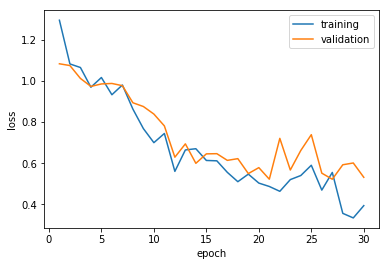

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Generating predictions from validation data...


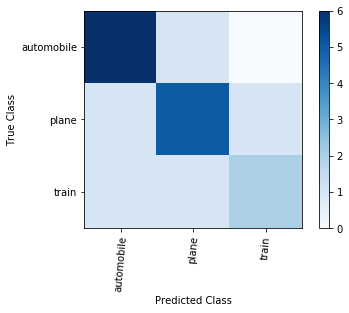

In [6]:
#Keras doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the moedl to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### Save the Model
Save the model with the trained weights. So later we can reload and use it to predict classes from new images.

In [7]:
from keras.models import load_model

modelFileName = 'vehicle-classifier.h5'

model.save(modelFileName) # saves the trained model
print("Model saved.")

del model  # deletes the existing model variable

Model saved.


### Use the Model with New Data


In [8]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # We need to format the input to match the training data
    # The data generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    img_features = image_array.astype('float32')
    img_features /= 255
    
    # These are the classes our model can predict
    classnames = ['automobile', 'plane', 'train']
    
    # Predict the class of each input image
    predictions = classifier.predict(img_features)
    
    predicted_classes = []
    for prediction in predictions:
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(class_idx)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


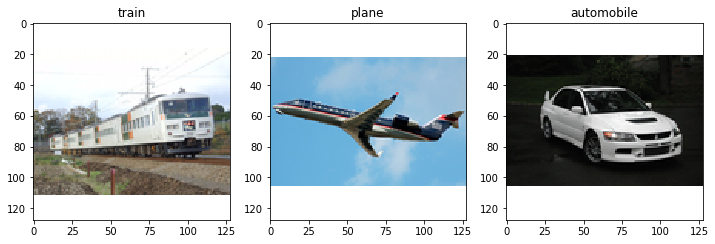

In [9]:
import os
from random import randint
import numpy as np
from PIL import Image
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

# load the saved model
modelFileName = 'vehicle-classifier.h5'
model = load_model(modelFileName) 

#get the list of test image files
test_folder = '../data/classification/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
                      
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])
